In [1]:
from torchvision import transforms
import torch
from torch.nn import functional as F
from torchvision.models import vgg19 # importa a vgg19, CNN com 16 Conv2d, 5 MaxPooling e 3 FC, pré treinada com o dataset ImageNet
import torch.nn as nn
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
preprocess = transforms.Compose([ # cria uma pipeline de preprocessamento
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normaliza cada dimensão das imagens com as repectivas médias e desvios padrão
    transforms.Lambda(lambda x: x.mul_(255)) # multiplica cada pixel do tensor por 255, passando de uma representação entre 0 e 1 para uma padrão de 8-bit
])
postprocess = transforms.Compose([ # cria uma pipeline de posprocessamento
    transforms.Lambda(lambda x: x.mul_(1./255)), # coloca os valores dos pixels entre 0. e 1.
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]) # reverte a normalização feita no preprocessamento
])

In [4]:
# definindo classes importantes para o processo
class GramMatrix(nn.Module):
    """
    Calcula a matriz Gram de uma imagem
    Essa matriz serve para capturar o estilo da imagem, através das correlações entre os feature maps gerados por convolução
    É gerada pela multiplição entre a matriz da imagem e sua transposta
    Cada elemento da matriz Gram representa a correlação entre dois feature maps diferentes
    """
    def forward(self, input_):
        b,c,h,w = input_.size() # b: número de batches; c: canais de feature; h: altura; w: largura
        feat = input_.view(b, c, h*w) # planifica as dimensões espaciais
        G = feat@feat.transpose(1, 2) # multiplica feat por sua transposta (com a segunda e terceira dimensẽos trocadas)
        G.div_(h*w) # divide, in-place, cada elemento de G por h*w, normalizando a matriz
        return G
    
class GramMSELoss(nn.Module):
    """
    Calcula o erro entre o estilo da matriz input e a matriz target
    """
    def forward(self, input_, target):
        out = F.mse_loss(GramMatrix()(input_), target)
        return out
    
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval() 
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

In [5]:
# cria uma instância da vgg19 modificada e a armazena em device
vgg = vgg19_modified().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 224MB/s] 


In [6]:
!wget https://easydrawingguides.com/wp-content/uploads/2016/10/how-to-draw-an-elephant-featured-image-1200-1024x822.png
!wget https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg

--2024-10-06 21:48:26--  https://easydrawingguides.com/wp-content/uploads/2016/10/how-to-draw-an-elephant-featured-image-1200-1024x822.png
Resolving easydrawingguides.com (easydrawingguides.com)... 104.16.150.108, 104.16.151.108, 2606:4700::6810:966c, ...
Connecting to easydrawingguides.com (easydrawingguides.com)|104.16.150.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188359 (184K) [image/png]
Saving to: 'how-to-draw-an-elephant-featured-image-1200-1024x822.png'

how-to-draw-an-elep 100%[===================>] 183.94K  --.-KB/s    in 0.01s   

2024-10-06 21:48:26 (12.9 MB/s) - 'how-to-draw-an-elephant-featured-image-1200-1024x822.png' saved [188359/188359]

--2024-10-06 21:48:27--  https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg
Resolving www.neh.gov (www.neh.gov)... 23.21.228.79
Connecting to www.neh.gov (www.neh.gov)|23.21.228.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5309491 (5.1M

In [7]:
from PIL import Image
# aplica o preprocessamento nas imagens baixadas e as armazena em device
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['Fall_2022_web-images_Picasso_32.jpg', 'how-to-draw-an-elephant-featured-image-1200-1024x822.png']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [8]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [9]:
style_layers = [0, 5, 10, 19, 28] 
content_layers = [21]
loss_layers = style_layers + content_layers

In [10]:
# define as funçẽos de erro
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [11]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]] 
content_weights = [1]
weights = style_weights + content_weights

In [12]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [13]:
from torch import optim
max_iters = 500
optimizer = optim.LBFGS([opt_img])

In [16]:
iters = 0
losses = []
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        losses.append(loss.cpu().detach().numpy())
        return loss
    optimizer.step(closure)

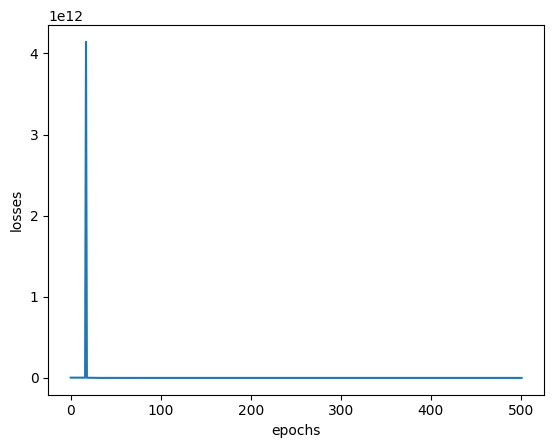

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()